# PREDICT FUTURE SALES : FINAL PROJECT
 
*By Muhammad Saqeeb, Cindy Lee*


1. Import Dataset & Libraries
2. Data Exploration
3. Prediction
4. Deciding Lagging Features
5. Improvements
6. 

## Import Dataset & Libraries

In [1]:
!pip install xgboost
!pip install missingno 



In [2]:
# System pacakges
import os
import sys
import re
import gc
import time
import datetime
import warnings
warnings.simplefilter("ignore")

# Data pacakges
import pickle
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling pacakges
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

# Pacakge settings
%matplotlib inline
sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sys.version_info

sys.version_info(major=3, minor=9, micro=12, releaselevel='final', serial=0)

In [5]:
print (os.listdir('../data'))


['.ipynb_checkpoints', '675', 'Behavior', 'csv', 'DataR', 'final (1).ipynb', 'hill.JPG', 'hill_line.JPG', 'HRM 601 Exam 2 Summer 22.docx', 'items.csv', 'items.csv.zip', 'item_categories.csv', 'LinkedIn-Easy-Apply-Bot-master.zip', 'linkedin_bot', 'ln2b-1.JPG', 'midterm.ipynb', 'old stuff', 'sales_train.csv', 'sales_train.csv.zip', 'sample_submission.csv', 'sample_submission.csv.zip', 'saqresume.pdf', 'shops.csv', 'software', 'test.csv', 'test.csv.zip']


In [9]:
train = pd.read_csv('..\\data\\sales_train.csv')
shops = pd.read_csv('..\\data\\shops.csv')
items = pd.read_csv('..\\data\\items.csv')
# Drop name to save space
items = items.drop('item_name', axis=1)
item_cat = pd.read_csv('..\\data\\item_categories.csv')
# Set index to ID to avoid droping it later
test = pd.read_csv('..\\data\\test.csv').set_index('ID')
# Add date_block_num = 34
test['date_block_num'] = 34
submission = pd.read_csv('..\\data\\sample_submission.csv')


In [10]:
print ('-------------------------------------------------------')
print ('train:')
for f in train.columns.values:
    print ('%s: %s ~ %s' %(f, train[f].min(), train[f].max()))
print ('-------------------------------------------------------')
print ('items:')
for f in items.columns.values:
    print ('%s: %s ~ %s' %(f, items[f].min(), items[f].max()))
print ('-------------------------------------------------------')
print ('test:')
for f in test.columns.values:
    print ('%s: %s ~ %s' %(f, test[f].min(), test[f].max()))

-------------------------------------------------------
train:
date: 01.01.2013 ~ 31.12.2014
date_block_num: 0 ~ 33
shop_id: 0 ~ 59
item_id: 0 ~ 22169
item_price: -1.0 ~ 307980.0
item_cnt_day: -22.0 ~ 2169.0
-------------------------------------------------------
items:
item_id: 0 ~ 22169
item_category_id: 0 ~ 83
-------------------------------------------------------
test:
shop_id: 2 ~ 59
item_id: 30 ~ 22167
date_block_num: 34 ~ 34


## Cleaning Data

In [11]:
def compress_columns(df,columns,keyword,search_type,datatype):
    if search_type=='in':
        valid_features = [x for x in columns if keyword in x]
    elif search_type=='start':
        valid_features = [x for x in columns if x.startswith(keyword)]
    if len(valid_features):
        for f in valid_features:
            df[f] = df[f].round().astype(datatype)
    return df

def data_compression(df):
    features = df.columns.values
    # Original features
    if 'date_block_num' in features:
        df['date_block_num'] = df['date_block_num'].astype(np.int8)
    if 'shop_id' in features:
        df['shop_id'] = df['shop_id'].astype(np.int8)
    if 'item_category_id' in features:
        df['item_category_id'] = df['item_category_id'].astype(np.int8)
    if 'item_id' in features:
        df['item_id'] = df['item_id'].astype(np.int16)
    if 'item_price' in features:
        df['item_price'] = df['item_price'].astype(np.float32)
    if 'item_id_avg_item_price' in features:
        df['item_id_avg_item_price'] = df['item_id_avg_item_price'].astype(np.float32)
        
    # Mean encoded features & lag features
    df = compress_columns(df,features,'item_id_sum_item_cnt_day','in',np.int16)
    df = compress_columns(df,features,'item_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'shop_id_avg_item_price','in',np.float16)
    df = compress_columns(df,features,'shop_id_sum_item_cnt_day','in',np.int16)
    df = compress_columns(df,features,'shop_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'item_category_id_avg_item_price','in',np.float16)
    df = compress_columns(df,features,'item_category_id_sum_item_cnt_day','in',np.int32)
    df = compress_columns(df,features,'item_category_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_columns(df,features,'item_cnt_day','start',np.int16)
    return df

In [12]:
# Compress features according to range
train = data_compression(train)
items = data_compression(items)
test = data_compression(test)

In [13]:
# Include Category id
train = pd.merge(train,items,on='item_id',how='left')
test = pd.merge(test,items, on='item_id', how='left')

### merge duplicated shops

In [14]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [16]:
#Check feature distrubutions
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int8   
 2   shop_id           int8   
 3   item_id           int16  
 4   item_price        float32
 5   item_cnt_day      int16  
 6   item_category_id  int8   
dtypes: float32(1), int16(2), int8(3), object(1)
memory usage: 75.6+ MB


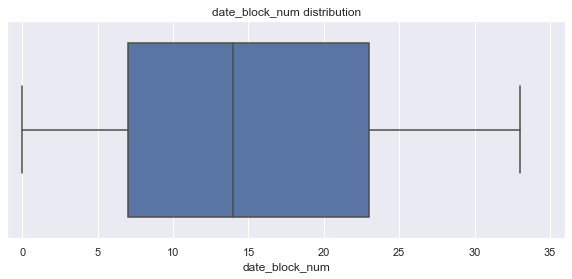

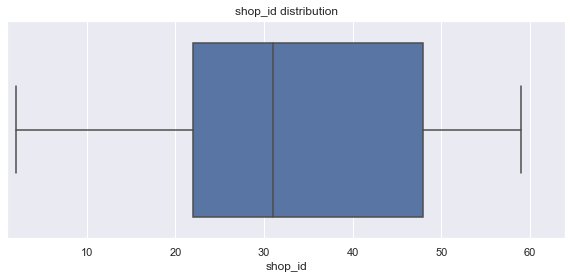

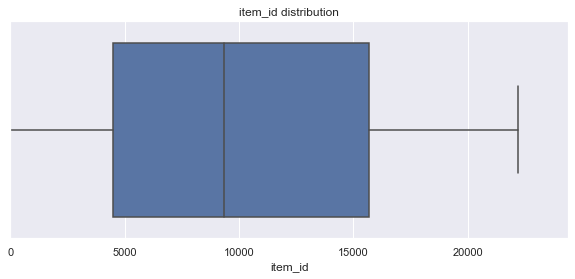

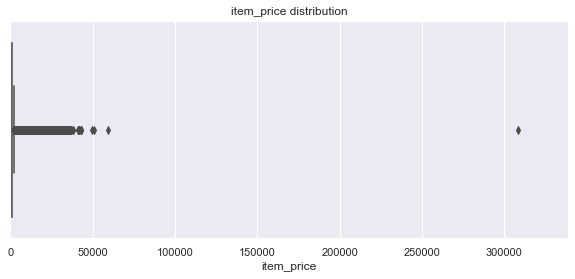

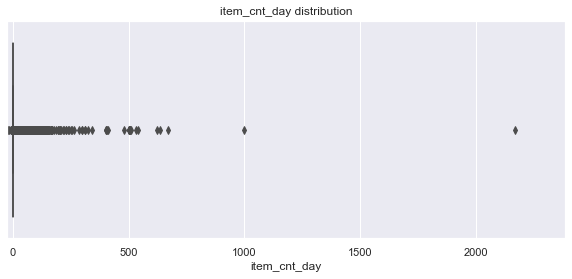

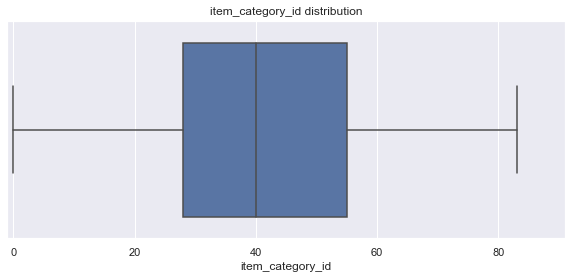

In [17]:
def box_plot(df,f):
    plt.figure(figsize=(10,4))
    plt.title(f+' distribution')
    x_min = int(df[f].min() - (abs(df[f].min())*0.1))
    x_max = int(df[f].max() + (abs(df[f].max())*0.1))
    if x_min==0:
        x_min = -1
    if x_max==0:
        x_max = 1
    plt.xlim(x_min,x_max)
    sns.boxplot(x=df[f])

plot_features = [x for x in train.columns.values if train[x].dtype != 'object']
for f in plot_features:
    box_plot(train,f)

So there are extreme outliers in 'item_price' and 'item_cnt_day'.


### Outlier removal

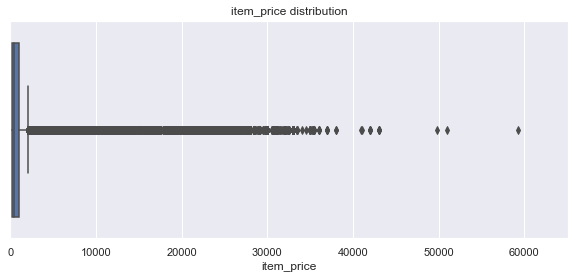

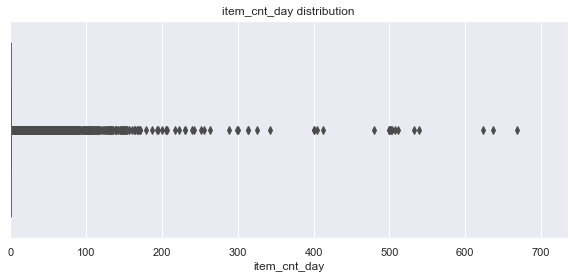

In [19]:
# Getting rid of the outliers & negative values
train = train[(train['item_price']<100000) & (train['item_price']>=0)]
train = train[(train['item_cnt_day']<1000) & (train['item_cnt_day']>=0)]

# distribution after outliers removal
plot_features = ['item_price','item_cnt_day']
for f in plot_features:
    box_plot(train,f)

In [21]:
# Created a dataframe of all Date_block_num, Store and Item combinations:
# So in case in the months some shops did not have the sale record of some item, it can be set to 0.

# Create a grid with columns
index_cols = ['shop_id','item_id','date_block_num']

# For every month we create a grid for all shops/items pair
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num']==block_num,'shop_id'].unique()
    cur_items = train.loc[train['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_cols,dtype=np.int32)
grid = data_compression(grid)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [22]:
grid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884508 entries, 0 to 10884507
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   shop_id         int8 
 1   item_id         int16
 2   date_block_num  int8 
dtypes: int16(1), int8(2)
memory usage: 41.5 MB


## Mean Encoding

In [23]:
# Group items per month, per shop, per item, sum the sales of the item, mean the price
# There is a big difference between np.mean and pandas mean
train_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
train_m = pd.merge(grid,train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
train_m = pd.merge(train_m,items,on='item_id',how='left')
train_m = data_compression(train_m)

In [24]:
# Making the mean encoded features
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = train.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        train_m = pd.merge(train_m, mean_df, on=['date_block_num',type_id], how='left')
        del mean_df
        gc.collect()

In [25]:
del train
gc.collect()

0

Fill NaNs

Because NaN cannot be converted to int, therefore NaN has to be filled.
Because there are many items which did not sale a single piece per store per month, there are many Nans.
The Nans in item count means 0 sold, therefore will be filled with 0.
The Nans in item price however means since there is no sale record of the item, the price is missin, therefore will be filled with median / mean price of the item.

In [26]:
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

# Compress data
train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10884508 entries, 0 to 10884507
Columns: 15 entries, shop_id to item_category_id_avg_item_cnt_day
dtypes: float16(5), float32(2), int16(4), int32(1), int8(3)
memory usage: 425.6 MB


In [27]:
# Check the positions of the base lag features
train_m.columns.values[6:]

array(['item_id_avg_item_price', 'item_id_sum_item_cnt_day',
       'item_id_avg_item_cnt_day', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'], dtype=object)

In [28]:
# Get all the monthly features, which means the Mean Encoded fatures are all monthly based
lag_features = list(train_m.columns[6:])+['item_cnt_day']
# The selected months from current month
lags = [1,2,3,6]

In [29]:
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    train_m = pd.merge(train_m,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [30]:
# Fill NaNs
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10884508 entries, 0 to 10884507
Columns: 55 entries, shop_id to item_cnt_day_lag_6
dtypes: float16(25), float32(6), int16(16), int32(5), int8(3)
memory usage: 1.4 GB


Clipping train data to make it similar to test set
In the evaluation data description on the competition page, it is said to clip target values to [0,20], because the test set ranges are in between these numbers.
In the next few lines I clipped the days to range[0,30].
You might ask me why 30. An intuitive answer is if I had clipped to range [0,20] there would be very few tree nodes that could give 20 as an answer.
While if I increase it to 40 having a 20 becomes much more easier.
Please note that We will clip our predictions in the [0,20] range in the end.

In [32]:
# Set the maximum clip value
max_clip = 30
train_m['item_cnt_day'] = train_m['item_cnt_day'].clip(0,max_clip).astype(np.float16)

## prep test set

In [33]:
# Add lag variables
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    test = pd.merge(test,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    gc.collect()
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [34]:
# Fill NaNs
for f in test.columns:
    if 'item_cnt' in f:
        test[f] = test[f].fillna(0)
    elif 'item_price' in f:
        test[f] = test[f].fillna(test[f].median())

test = data_compression(test)

In [35]:
cols_to_drop = lag_features[:-1] + ['item_price']
print ('Columns to drop')
print (cols_to_drop)

Columns to drop
['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [36]:
train_cols = train_m.columns.values
test_cols = test.columns.values
for c in cols_to_drop:
    if c in train_cols:
        train_m = train_m.drop(c,axis=1)
    if c in test_cols:
        test = test.drop(c,axis=1)

In [37]:
# Month number
train_m['month'] = train_m['date_block_num']%12
train_m['month'] = train_m['month'].astype(np.int8)
# Number of days in a month, no leap years here
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_m['days'] = train_m['month'].map(days).astype(np.int8)

test['month'] = 11
test['month'] = test['month'].astype(np.int8)
test['days'] = 30
test['days'] = test['days'].astype(np.int8)

In [38]:
# Check if lag var in test set are correct

# Assert all the columns are the same except target column
set(train_m.columns.values) ^ set(test.columns.values)

{'item_cnt_day'}

In [39]:
train_m.head()


,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,59,22154,0,1.00,37,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
1,59,2552,0,0.00,58,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
2,59,2554,0,0.00,58,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
3,59,2555,0,0.00,56,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31
4,59,2564,0,0.00,59,299.00,0,0.00,879.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,872.00,0,0.00,379.00,0,0.00,0,299.00,0,0.00,868.00,0,0.00,376.00,0,0.00,0,299.00,0,0.00,847.00,0,0.00,376.00,0,0.00,0,0,31


In [40]:
test.head()


,shop_id,item_id,date_block_num,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_price_lag_1,item_category_id_sum_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_1,item_cnt_day_lag_1,item_id_avg_item_price_lag_2,item_id_sum_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_2,shop_id_avg_item_price_lag_2,shop_id_sum_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_price_lag_2,item_category_id_sum_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_2,item_cnt_day_lag_2,item_id_avg_item_price_lag_3,item_id_sum_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_3,shop_id_avg_item_price_lag_3,shop_id_sum_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_price_lag_3,item_category_id_sum_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_3,item_cnt_day_lag_3,item_id_avg_item_price_lag_6,item_id_sum_item_cnt_day_lag_6,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,5,5037,34,19,1499.00,25,1.00,1028.00,1054,1.00,1680.00,2450,1.00,0,936.68,111,1.00,1037.00,1098,1.00,1360.00,3998,1.00,1,894.59,119,1.00,911.00,1297,1.00,1140.00,4674,1.00,3,1542.87,87,1.00,959.00,1013,1.00,1418.00,3407,1.00,1,11,30
1,5,5320,34,55,449.00,0,0.00,1240.00,0,0.00,510.00,0,0.00,0,432.00,0,0.00,1204.00,0,0.00,511.00,0,0.00,0,437.10,0,0.00,969.00,0,0.00,488.00,0,0.00,0,437.75,0,0.00,1099.00,0,0.00,559.00,0,0.00,0,11,30
2,5,5233,34,19,1199.00,42,1.00,1028.00,1054,1.00,1680.00,2450,1.00,1,711.71,80,1.00,1037.00,1098,1.00,1360.00,3998,1.00,3,712.15,150,1.00,911.00,1297,1.00,1140.00,4674,1.00,1,790.03,71,1.00,959.00,1013,1.00,1418.00,3407,1.00,3,11,30
3,5,5232,34,23,1190.14,29,1.00,1028.00,1054,1.00,1796.00,2213,1.00,0,703.49,48,1.00,1037.00,1098,1.00,1269.00,3610,1.00,0,642.47,65,1.00,911.00,1297,1.00,1164.00,3666,1.00,1,437.75,0,0.00,1099.00,0,0.00,559.00,0,0.00,0,11,30
4,5,5268,34,20,449.00,0,0.00,1240.00,0,0.00,510.00,0,0.00,0,432.00,0,0.00,1204.00,0,0.00,511.00,0,0.00,0,437.10,0,0.00,969.00,0,0.00,488.00,0,0.00,0,437.75,0,0.00,1099.00,0,0.00,559.00,0,0.00,0,11,30


In [41]:
test[['shop_id','item_id']+['item_cnt_day_lag_'+str(x) for x in [1,2,3]]].head()


,shop_id,item_id,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3
0,5,5037,0,1,3
1,5,5320,0,0,0
2,5,5233,1,3,1
3,5,5232,0,0,1
4,5,5268,0,0,0


In [42]:
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 33]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 32]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 31]['item_cnt_day'])

10820113   0.00
Name: item_cnt_day, dtype: float16
10581628   1.00
Name: item_cnt_day, dtype: float16
10372045   3.00
Name: item_cnt_day, dtype: float16


In [43]:
train_m = train_m[train_m['date_block_num']>12]


In [44]:
train_set = train_m[train_m['date_block_num']<33]
val_set = train_m[train_m['date_block_num']==33]

In [45]:
print (train_set.shape)
print (val_set.shape)
print (test.shape)

(5820464, 47)
(238084, 47)
(214200, 46)


In [46]:
# Save data
train_set.to_pickle('train.pkl')
val_set.to_pickle('val.pkl')
test.to_pickle('test.pkl')

In [48]:
del train_m
gc.collect()

485

# Modeling

1. Ridge Regression (Linear)

In [49]:
# divide data into x & y
train_x = train_set.drop(['item_cnt_day'],axis=1)
train_y = train_set['item_cnt_day']
val_x = val_set.drop(['item_cnt_day'],axis=1)
val_y = val_set['item_cnt_day']

features = list(train_x.columns.values)

In [50]:
# Check if the data sets have equal amount of features
print (train_x.shape)
print (train_y.shape)
print (val_x.shape)
print (val_y.shape)
print (test.shape)

(5820464, 46)
(5820464,)
(238084, 46)
(238084,)
(214200, 46)


In [51]:
del train_set
del val_set
gc.collect()

0

In [52]:
# For saving data & output results / models
def post_processing(model,model_name,train_x,val_x,test_x,train_y,val_y,test):
    # Here we once again clip the output to 0~20
    train_pred = model.predict(train_x).clip(0, 20)
    val_pred = model.predict(val_x).clip(0, 20)
    test_pred = model.predict(test_x).clip(0, 20)

    # Get rmse scores
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    print("Train RMSE: %f" % (train_rmse))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    print("Val RMSE: %f" % (val_rmse))
    
    # Export submission
    submission = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred})
    submission.to_csv('%s_submission.csv'%model_name,index=False)

    # save model to file
    pickle.dump(lm, open("%s_model.pickle" %model_name, "wb"))
    return train_pred,val_pred,test_pred



Ridge Regression

In [53]:
# For plotting feature importance
def plot_feature_importances(importances,indices,features,title,dimensions):
    plt.figure(figsize=dimensions)
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()   

In [54]:
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x.values)
train_x_norm = scaler.transform(train_x.values)
val_x_norm = scaler.transform(val_x.values)
test_norm = scaler.transform(test.values)


In [55]:
# Training
gc.collect()
ts = time.time()
# Training
lm = linear_model.Ridge()
lm.fit(train_x_norm,train_y)
print ('Training time: %s' %(time.time() - ts))


Training time: 4.708283424377441


In [56]:
# Performance and test predictions
train_pred1,val_pred1,test_pred1 = post_processing(lm,'ridge',train_x_norm,val_x_norm,test_norm,train_y,val_y,test)

Train RMSE: 1.153216
Val RMSE: 1.169679


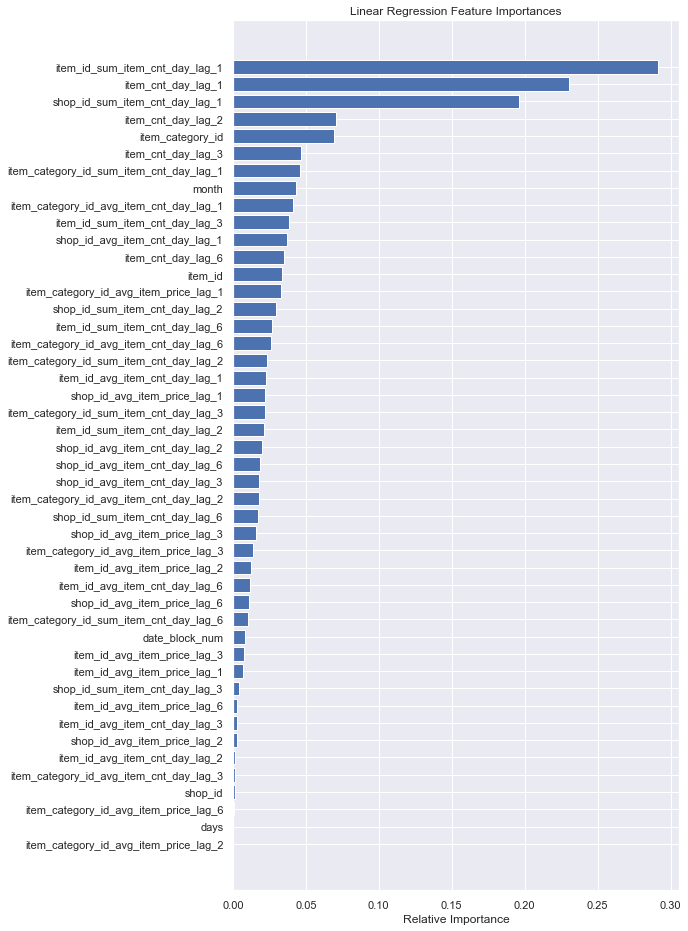

In [57]:
# Feature Importance
importances = abs(lm.coef_)
indices = np.argsort(importances)
title = 'Linear Regression Feature Importances'
plot_feature_importances(importances,indices,features,title,(8,16))

In [58]:
del train_x_norm
del val_x_norm
del test_norm
gc.collect()

8461

# Improvements to Model

1. xgboost = uses nividia gpu speed to run larger data much more quickly

2. backward selection

## xgboost

In [60]:
# Training
gc.collect()
ts = time.time()
xgbtrain = xgb.DMatrix(train_x.values, train_y.values)

param = {'max_depth':8, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'verbosity':2,
         'eval_metric':'rmse'} # random parameters

bst = xgb.train(param, xgbtrain)
print ('Training time: %s' %(time.time() - ts))

[09:29:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:29:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[09:29:30] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/data/simple_dmatrix.cc:102: Generating new Gradient Index.
Training time: 17.179703950881958


In [62]:
# Performance and test predictions
train_pred2,val_pred2,test_pred2 = post_processing(bst,'xgboost',xgb.DMatrix(train_x.values),
                                                   xgb.DMatrix(val_x.values),xgb.DMatrix(test.values),train_y,val_y,test)

MemoryError: Unable to allocate 1.99 GiB for an array with shape (46, 5820464) and data type float64

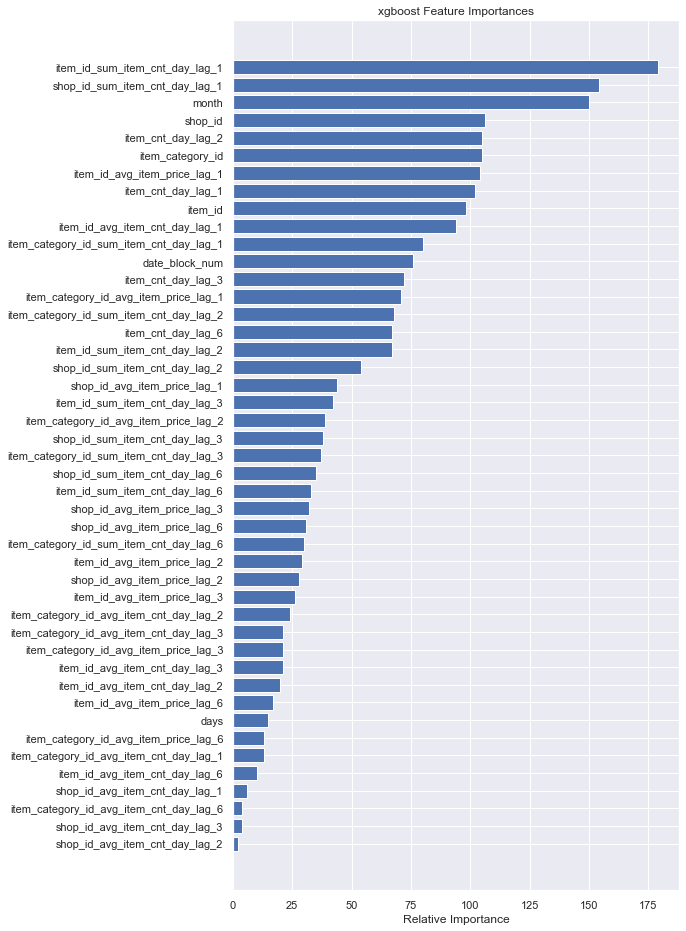

In [63]:
# Feature Importance
import operator
importance = sorted(bst.get_score().items(), key=operator.itemgetter(1))
importance_v = np.asarray([x[1] for x in importance],dtype=np.int16)
indices = np.asarray([int(x[0].replace('f','')) for x in importance],dtype=np.int8)
title = 'xgboost Feature Importances'

plt.figure(figsize=(8,16))
plt.title(title)
plt.barh(range(len(indices)), importance_v, color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show() 

### Map Categories

In [ ]:
l_cat = list(item_cat.item_category_name)

l_cat[0] = 'PC Headsets'

for ind in range(1,8):
    l_cat[ind] = 'Accessories'
    
l_cat[8] = 'Tickets'  
l_cat[9] = 'Goods'    

for ind in range(10,18):
    l_cat[ind] = 'Game consoles'

for ind in range(18,32):
    l_cat[ind] = 'Games'

for ind in range(32,37):
    l_cat[ind] = 'Payment cards'

for ind in range(37,43):
    l_cat[ind] = 'Movie'

for ind in range(43,55):
    l_cat[ind] = 'Books'

for ind in range(55,61):
    l_cat[ind] = 'Music'

for ind in range(61,73):
    l_cat[ind] = 'Presents'

for ind in range(73,79):
    l_cat[ind] = 'Programs'

l_cat[79] = 'Service'  
l_cat[80] = 'Service'

l_cat[81] = 'Clean media'  
l_cat[82] = 'Clean media'

l_cat[83] = 'Batteries' 

item_cat['cats'] = l_cat

In [ ]:
items = pd.merge(items, item_cat, on=['item_category_id'], how='left')


In [ ]:
items = items[['item_id', 'cats']]


### EDA

In [ ]:
train.describe()


In [ ]:
train.head()

In [ ]:
test.describe()

In [ ]:
test.head()

In [ ]:
train.shop_id.unique().shape
test.shop_id.unique().shape
set(test.shop_id.unique()) < set(train.shop_id.unique())
train.item_id.unique().shape
test.item_id.unique().shape
set(test.item_id.unique()) < set(train.item_id.unique())
train.item_price.hist() #bins=10


In [ ]:
train.item_cnt_day.hist()


In [ ]:
train = train[train['item_price'] < 100000]
train = train[train['item_cnt_day'] < 1000]

## Data Exploration

In [ ]:
shops.head()


In [ ]:
items.head()


In [ ]:
item_cat.head()


In [ ]:
test.head()


In [ ]:
submission.head()

In [ ]:
train = train.loc[(train.item_price < 100000) & (train.item_cnt_day <= 1000) & (train.item_price >=0)]


In [ ]:
# Perform the aggregation according to every month.

dfs = []
for month_block in train.date_block_num.unique():
    print('Making dataframe for: %s' %(month_block+1))
    df = pd.DataFrame(train[train['date_block_num'] == month_block].groupby(['shop_id', 'item_id'])['item_cnt_day'].sum())
    df.reset_index(inplace = True)
    df['date_block_num'] = month_block
    dfs.append(df)
    
df = pd.DataFrame()
for frame in dfs:
    df = pd.concat([df, frame], axis = 0)
train = df.copy()

In [ ]:
#check this package out for useful exploration of missing data in dataset.


In [ ]:
import missingno as msno

def aggregate_cols(row):
    return str(int(row['shop_id'])) + str(int(row['item_id']))
train['agg_id'] = train.apply(lambda row: aggregate_cols(row), axis = 1)
test['agg_id'] = test.apply(lambda row: aggregate_cols(row), axis = 1)

dic = {}
ids = train.agg_id.unique().tolist()
for id  in ids:
    dic[id] = 0

test['agg_id'] = test['agg_id'].map(dic)

In [ ]:
plt.style.use('ggplot')
msno.bar(test)

## Predictions

### Famous Shops

In [ ]:
train = pd.merge(train, shops, on = 'shop_id', how = 'inner')
Z = dict(train['shop_name'].value_counts())
fig, ax = plt.subplots(1, figsize=(15, 5))
sns.stripplot(list(Z.keys()), list(Z.values()), ax = ax)
plt.xticks(rotation = 90)
plt.show()

### Famous Items categories

In [ ]:
item_desc = pd.merge(items, item_cat, how='inner', on='item_category_id')
train = pd.merge(train, item_desc[['item_id', 'item_category_name', 'item_category_id']], on = 'item_id', how = 'inner')

Z = dict(train['item_category_name'].value_counts())
fig, ax = plt.subplots(1, figsize=(18, 5))
sns.stripplot(list(Z.keys()), list(Z.values()), ax = ax, edgecolor='black', size=5)
plt.xticks(rotation = 90)
plt.title('Item Categories set according to Frequency')
plt.show()

### joint plots

In [ ]:
sns.jointplot('shop_id', 'item_category_id', data = train, space = 0, size = 15, ratio = 5)
plt.yticks(range(90))
plt.show()

In [ ]:
test = pd.merge(test, item_desc[['item_id', 'item_category_name', 'item_category_id']], on = 'item_id', how = 'inner')
sns.jointplot('shop_id', 'item_category_id', data = test, space = 0, size = 15, ratio = 5)
plt.yticks(range(90))
plt.show()

In [ ]:
test['date_block_num'] = 34
g = pd.concat([train[['shop_id', 'date_block_num']], test[['shop_id', 'date_block_num']]])
sns.jointplot('date_block_num', 'shop_id', data = g, space = 0, size = 15, ratio = 5)
plt.yticks(range(90))
plt.show()

This joint plot of shops across the date block numbers give us an idea of the behavior of the shops with the timeline. I found following observations to be quite useful:

The 34th month is mostly dependent [perfectly coinciding] on previous month sales information. This means that the shops that are present in november are mostly present in previous months except a few. This gives somewhat idea about validation.
Some shops like 0, 1, 32, etc. had a very short time period with 1c company which mean either they were closed or they their agreement got over with the company.
Some shops are quite seasonal or they have 1c company as their backup arrangements. This gives the insight that they won't be their in test data.

### New shelved items per month

In [ ]:
df = train[train.date_block_num >= 12]
months = np.sort(df.date_block_num.unique())
new_items_introduced = [0] * 12
for i in range(12, len(months)):
    new_items_introduced[i%12] += len(np.setdiff1d(df[df.date_block_num == months[i]]['item_id'].unique(), df[df.date_block_num < months[i]]['item_id'].unique()))

names = ['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']       
plt.figure(figsize = (15, 5))
plt.bar(np.arange(1,13), new_items_introduced)
plt.title('Items introduced over months')
plt.xticks(np.arange(1,13))
plt.show()


my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(new_items_introduced, labels=names)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Items sold out

In [ ]:
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
hb1 = ax.hexbin(train.shop_id, train.item_id, cmap = 'inferno')
plt.title('Hexagonal Binning for the items present in the shops')
plt.xticks(np.arange(0,60))
plt.xlabel('Shop Id')
plt.ylabel('Item Id')
plt.show()

From the visualization a couple of things are quite clearer:

Shops from 25 to 28, 31 and 54 are locate in main markets somewhere and are quite a large scale shops and thus, have almost all the items present in quite a large amount
Some shops like 0, 1, 8, 9 etc. have almost next to nothing which indicates that either these shops were open for some time and get closed afterwards or they are very small scale shops.
Shops like 2,3,4,10,12,etc. have limited item ids which indicates they are quite specific in what they are selling at a time [May be a cd store or game store or gift shop].

## Deciding Lag Features

In [ ]:
Z = train.groupby('date_block_num').agg({'item_cnt_day': sum}).reset_index()
fig, ax = plt.subplots(ncols=1, sharey=True, figsize = (20,10))
sns.barplot(data=Z, x='date_block_num', y='item_cnt_day', ax = ax, palette="BrBG")
plt.title('Overall Item counts over the course of 3 years')
plt.show()

The general trend suggests that, the item counts are decreasing over the time till a certain time (roughly around May or June). The graph also suggests that there is a seasonality of around 12 months which means that the trend tends to repetitive over the time. Thus, we can take the lag features of roughly around 5 to 6 time periods along with 12 for seasonality purposes.

In [78]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

ModuleNotFoundError: No module named 'mlxtend'

In [77]:
# Build RF classifier to use in feature selection
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

# Build step forward feature selection
sfs1 = sfs(clf,
           k_features=5,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(train_x, train_y)

NameError: name 'RandomForestClassifier' is not defined